In [20]:
#-- リスト 7-1-(1)
import numpy as np
# データ生成 --------------------------------
np.random.seed(seed=1)  # 乱数を固定
N = 200  # データの数
K = 3  # 分布の数
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]  # X0 の範囲 , 表示用
X_range1 = [-3, 3]  # X1 の範囲 , 表示用
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])  # 分布の中心
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])  # 分布の分散
Pi = np.array([0.4, 0.8, 1])  # 各分布への割合
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
                   Mu[T[n, :] == 1, k]

In [21]:
#-- リスト 7-1-(2)
# -------- 2 分類のデータをテスト・訓練データに分割
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

# -------- データを 'class_data.npz' に保存
np.savez('class_data.npz', X_train=X_train, T_train=T_train, 
                           X_test=X_test, T_test=T_test,
                           X_range0=X_range0, X_range1=X_range1)

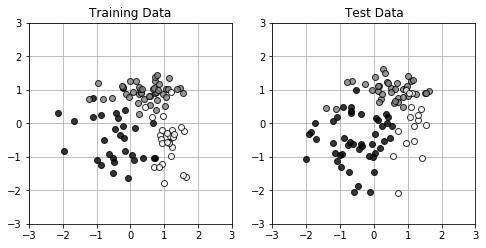

In [22]:
#-- リスト 7-1-(3)
import matplotlib.pyplot as plt
%matplotlib inline

# データの図示 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)
# メイン ------------------------------------
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [23]:
# リスト 7-1-(4)
# シグモイド関数 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

# ネットワーク  ------------------------
def FNN(wv, M, K, x):
    N, D = x.shape  # 入力次元
    w = wv[:M * (D + 1)] # 中間層ニューロンへの重み
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 出力層ニューロンへの重み
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1))  # 中間層ニューロンの入力総和
    z = np.zeros((N, M + 1))  # 中間層ニューロンの出力
    a = np.zeros((N, K))  # 出力層ニューロンの入力総和
    y = np.zeros((N, K))  # 出力層ニューロンの出力
    for n in range(N):
        # 中間層の計算
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])  # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 出力層の計算
        z[n, M] = 1  # ダミーニューロン
        wkz = 0
        for k in range(K): 
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b

# test ---
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[ 0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333]]),
 array([[ 2.6971835 ,  2.6971835 ,  2.6971835 ],
        [ 1.49172649,  1.49172649,  1.49172649]]),
 array([[ 0.84859175,  0.84859175,  1.        ],
        [ 0.24586324,  0.24586324,  1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [24]:
# リスト 7-1-(5)
# 平均交差エントロピー誤差 ---------
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

# test --- 
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :]) 

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


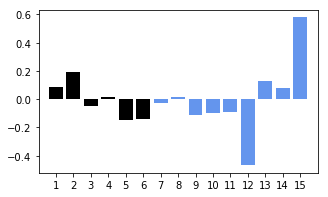

In [25]:
# リスト 7-1-(6)
# - 数値微分 ------------------
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv

#--dVW の表示 ------------------
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
#-test----
M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

In [26]:
# リスト 7-1-(7)
import time

# 数値微分を使った勾配法 -------
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n): # (A)
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

# メイン ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000     #  (B) 学習ステップ
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:144.843 sec


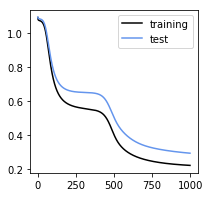

In [27]:
# リスト 7-1-(8)
# 学習誤差の表示 ---------------------------
plt.figure(1, ﬁgsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.show()

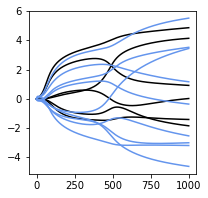

In [28]:
# リスト 7-1-(9)
# 重みの時間発展の表示 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

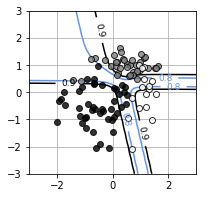

In [29]:
# リスト 7-1-(10)
# 境界線表示関数 --------------------------
def show_FNN(wv, M, K):
    xn = 60  # 等高線表示の解像度
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize = (4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9], 
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt = '%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

# 境界線の表示 --------------------------
plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


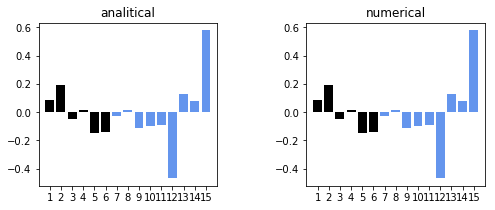

In [30]:
# リスト 7-1-(11)
# -- 解析的微分 -----------------------------------
def dCE_FNN(wv, M, K, x, t):
    N, D = x.shape
    # wv を w と v に戻す
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))
    # ① x を入力して y を得る
    y, a, z, b = FNN(wv, M, K, x)
    # 出力変数の準備
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M)  # 1 層目誤差
    delta2 = np.zeros(K)  # 2 層目誤差 (k = 0 の部分は使わず )
    for n in range(N): # (A)
        # ②出力層の誤差を求める
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
        # ③中間層の誤差を求める
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        # ④ v の勾配 dv を求める
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        # ④ w の勾配 dw を求める
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
    # dw と dv を合体させて dwv とする
    dwv = np.c_[dw.reshape((1, M * (D + 1))), 
                dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    return dwv

#------Show VW
def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], 
            align = "center", color = 'black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align = "center", color = 'cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)

#-- 動作確認
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [31]:
# リスト 7-1-(12)

import time
# 解析的微分を使った勾配法 -------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n):
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test

# メイン ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:18.796 sec


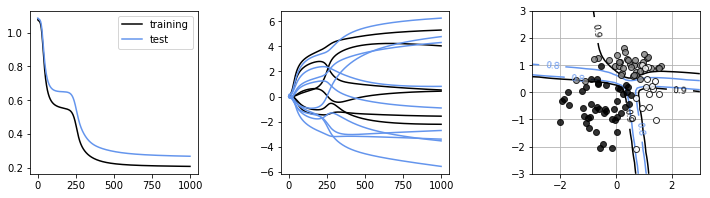

In [32]:
# リスト 7-1-(13)
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 学習誤差の表示 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 重みの時間発展の表示 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
# 境界線の表示 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

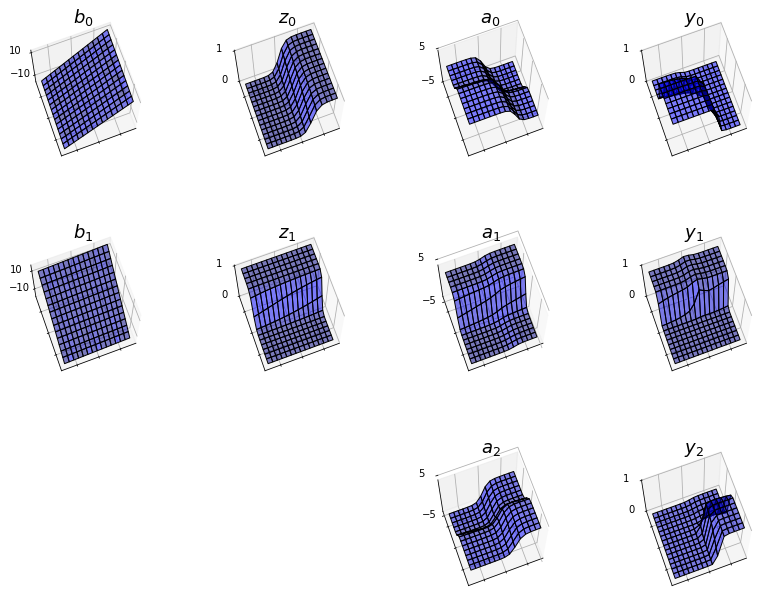

In [33]:
# リスト 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color = 'blue', edgecolor = 'black',
                    rstride=1, cstride = 1, alpha=0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize = 18)

M = 2
K = 3
xn = 15  # 等高線表示の解像度
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y, a, z, b = FNN(WV, M, K, x)

ﬁg = plt.figure(1, figsize = (12, 9))
plt.subplots_adjust(left = 0.075, bottom = 0.05, right = 0.95,
                    top = 0.95, wspace = 0.4, hspace = 0.4)
for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection = '3d')
    show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection = '3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))
    
for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection = '3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection = '3d')
    show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))
    
plt.show()

In [34]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [35]:
# リスト 7-2-(1)
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1) # (A)
import keras.optimizers # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
# データーの load ---------------------------
outﬁle = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [36]:
# リスト 7-2-(2)
# データの図示 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle = 'none', marker = 'o',
                 markeredgecolor = 'black',
                 color = c[i], alpha = 0.8)
    plt.grid(True)

In [37]:
# リスト 7-2-(3)

# 乱数の初期化
np.random.seed(1)

# --- Sequential モデルの作成
model = Sequential()
model.add(Dense(2, input_dim = 2, activation = 'sigmoid',
           kernel_initializer = 'uniform'))  # (A)
model.add(Dense(3,activation = 'softmax', 
           kernel_initializer = 'uniform'))  # (B)
sgd = keras.optimizers.SGD(lr = 0.5, momentum = 0.0,
                           decay = 0.0, nesterov = False)  # (C)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy',
              metrics = ['accuracy'])  # (D)

# ---------- 学習
startTime = time.time()
history = model.ﬁt(X_train, T_train, epochs = 1000, batch_size = 100,
                    verbose = 0, validation_data = (X_test, T_test))  # (E)

# ---------- モデル評価
score = model.evaluate(X_test, T_test, verbose = 0)  # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'\
                     .format(score[0], score[1])) 
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.30, accuracy 0.88
Calculation time:1.548 sec


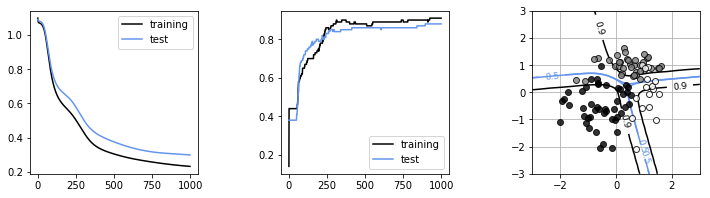

In [38]:
# リスト 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習曲線表示  --------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') #(B)
plt.legend()

# 精度表示  --------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], 'black', label='training') # (C)
plt.plot(history.history['val_acc'], 'cornflowerblue', label='test') #(D)
plt.legend()

# 境界線表示  --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60  # 等高線表示の解像度
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y = model.predict(x) # (E)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=[
                       'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()